# Yetiphoenix_BlackScholes_WorstOf3_Learning

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%matplotlib notebook

import numpy as np
import tensorflow as tf
import scipy.stats as ss
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,Conv1D,LeakyReLU
from tensorflow.keras import Model,Input
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import  BatchNormalization,Dropout,Reshape
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
import pandas as pd
import copy
import os
import zipfile
import time
from math import floor,modf,erf
from numpy import sqrt, exp, log,sin,cos,linspace, random
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d,interp2d
from scipy import interp, arange, exp, interpolate
from scipy.optimize import minimize
from scipy.stats import norm
print('TensorFlow version:', tf.__version__)
from bokeh.plotting import figure,show,output_file,output_notebook
output_notebook()
tf.keras.backend.set_floatx('float64')   

TensorFlow version: 2.4.0


Loading BokehJS ...

In [3]:
dataset_path = "yetiphoenix_totalDataset.csv"
df_total=pd.read_csv(dataset_path, sep=';')

In [4]:
df_total.columns

Index(['Unnamed: 0', 'S1', 'S2', 'S3', 'mu1', 'mu2', 'mu3', 'sigma1', 'sigma2',
       'sigma3', 'rho12', 'rho13', 'rho23', 'bonus', 'YetiBarrier',
       'YetiCoupon', 'PhoenixBarrier', 'PhoenixCoupon', 'PDIBarrier',
       'PDIGearing', 'PDIStrike', 'PDIType', 'maturity', 'nbDates', 'price',
       'forward1', 'forward2', 'forward3', 'forward4', 'forward5', 'forward6',
       'forward7', 'forward8', 'forward9', 'forward10', 'forward11',
       'forward12', 'forward13', 'forward14', 'forward15', 'forward16',
       'forward17', 'forward18', 'forward19', 'forward20', 'forward21',
       'forward22', 'forward23'],
      dtype='object')

In [5]:
def get_initial_dataset(df_total,batch_size,Conv_Flag):
    InputCols=['S1', 'S2', 'S3', 'mu1', 'mu2', 'mu3', 'sigma1', 'sigma2',
       'sigma3', 'rho12', 'rho13', 'rho23', 'bonus', 'YetiBarrier',
       'YetiCoupon', 'PhoenixBarrier', 'PhoenixCoupon', 'PDIBarrier',
       'PDIGearing', 'PDIStrike', 'PDIType', 'maturity', 'nbDates']

    df_train_xs = df_total[InputCols];    
    df_train_ys = df_total['price'];
    x_values = df_train_xs.values
    y_values = df_train_ys.values
    print("nombre de data selectionnés : ",x_values.shape[0])  
    return x_values,y_values

In [6]:
batch_size=32
Conv_Flag =True
x_values,y_values= get_initial_dataset(df_total,batch_size,Conv_Flag)

nombre de data selectionnés :  2410000


In [7]:
from sklearn.preprocessing import MinMaxScaler
Xscaler = MinMaxScaler()
Xscaler.fit(x_values)
Normalized_x_values = Xscaler.transform(x_values)

In [8]:
# pour inverser : inverse = scaler.inverse_transform(normalized)

In [9]:
 x_values_conv=Normalized_x_values.reshape(Normalized_x_values.shape[0], Normalized_x_values.shape[1],1)    

# nouveau modele

In [10]:
def build_conv_model(x_train_dim, leaky_factor, drop_out):
    model = Sequential() 
    model.add(Conv1D(128,2, input_shape=(x_train_dim,1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Dropout(drop_out))
    model.add(Dense(512))
    model.add(LeakyReLU(leaky_factor))
    model.add(BatchNormalization())
    model.add(Dropout(drop_out))
    model.add(Dense(256))
    model.add(LeakyReLU(leaky_factor))
    model.add(BatchNormalization())
    model.add(Dropout(drop_out))
    model.add(Dense(128))
    model.add(LeakyReLU(leaky_factor))
    model.add(BatchNormalization())
    model.add(Dropout(drop_out))
    model.add(Dense(64))
    model.add(LeakyReLU(leaky_factor))
    model.add(BatchNormalization())
    model.add(Dropout(drop_out))
    model.add(Dense(32))
    model.add(LeakyReLU(leaky_factor))
    model.add(BatchNormalization())
    model.add(Dropout(drop_out))
    model.add(Dense(1))
    return model

def get_conv_model(x_train_dim, leaky_factor, drop_out):
    model = build_conv_model(x_train_dim, leaky_factor, drop_out)
    optimizer=tf.keras.optimizers.Adam()
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])   
    print(model.summary())
    return model

class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, fraction, loss_to_monitor1,loss_to_monitor2 ):
        super(CustomCallback, self).__init__()
        
        self.fraction = fraction
        self.loss_to_monitor1 =loss_to_monitor1
        self.loss_to_monitor2 =loss_to_monitor2
        self.train_a = []
        self.val_a = []
        
        with open('log.txt', 'w') as f:
            f.write('Start of log\n')
        
        self.fig = plt.figure(figsize=(4, 3))
        self.ax = plt.subplot(1, 1, 1)
        plt.ion()
    
    def on_train_begin(self, logs=None):
        self.fig.show()
        self.fig.canvas.draw()
    
    def on_train_end(self, logs=None):
        with open('log.txt', 'a') as f:
            f.write('End of log\n')
    
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.fraction * tf.keras.backend.get_value(self.model.optimizer.lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        with open('log.txt', 'a') as f:
            f.write('Epoch:{:02d}, Learning Rate:{:.4f}, '.format(epoch, lr))
        
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get( self.loss_to_monitor2)
        if (val_acc is None) :
            print( self.loss_to_monitor2 + ' is none')
        train_acc = logs.get( self.loss_to_monitor1)
        if (train_acc is None) :
            print( self.loss_to_monitor1 + ' is none')
        
        self.train_a.append(train_acc)
        self.val_a.append(val_acc)
        
        with open('log.txt', 'a') as f:
            f.write('Train Msle:{:.3f}, Val Msle:{:.3f}\n'.format(train_acc , val_acc))
        
        self.ax.clear()
        self.ax.plot(range(epoch + 1), self.train_a, label='Training MSLE')
        self.ax.plot(range(epoch + 1), self.val_a, label='Validation MSLE')
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('MSLE')
        self.ax.legend()
        self.fig.canvas.draw()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 22, 128)           384       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2816)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              2884608   
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

<IPython.core.display.Javascript object>


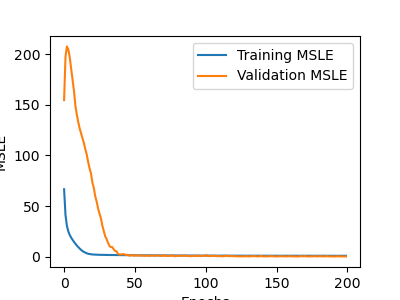

In [21]:
x_train_dim =x_values_conv.shape[1]
model=get_conv_model(x_train_dim, leaky_factor, drop_out)
monitor_cb = CustomCallback(fraction,'mse' , 'val_mse')

In [22]:
history = model.fit(x_values_conv,y_values,epochs=200,batch_size=90000, validation_split = 0.2, callbacks=[monitor_cb])

Epoch 1/200
22/22 [==============================] - 90s 4s/step - loss: 80.5344 - mae: 6.0966 - mse: 80.5344 - val_loss: 154.4700 - val_mae: 8.2136 - val_mse: 154.4700
Epoch 2/200
22/22 [==============================] - 89s 4s/step - loss: 44.1420 - mae: 5.3812 - mse: 44.1420 - val_loss: 197.3817 - val_mae: 10.0483 - val_mse: 197.3817
Epoch 3/200
22/22 [==============================] - 87s 4s/step - loss: 31.9573 - mae: 4.9600 - mse: 31.9573 - val_loss: 207.4084 - val_mae: 10.5157 - val_mse: 207.4084
Epoch 4/200
22/22 [==============================] - 87s 4s/step - loss: 25.8873 - mae: 4.6434 - mse: 25.8873 - val_loss: 204.4597 - val_mae: 10.3822 - val_mse: 204.4597
Epoch 5/200
22/22 [==============================] - 88s 4s/step - loss: 22.0777 - mae: 4.3638 - mse: 22.0777 - val_loss: 196.6246 - val_mae: 10.0502 - val_mse: 196.6246
Epoch 6/200
22/22 [==============================] - 88s 4s/step - loss: 19.3633 - mae: 4.1087 - mse: 19.3633 - val_loss: 185.5667 - val_mae: 9.5859 - 

22/22 [==============================] - 89s 4s/step - loss: 1.0823 - mae: 0.6162 - mse: 1.0823 - val_loss: 0.7484 - val_mae: 0.5547 - val_mse: 0.7484
Epoch 99/200
22/22 [==============================] - 90s 4s/step - loss: 1.0817 - mae: 0.6160 - mse: 1.0817 - val_loss: 0.7318 - val_mae: 0.5330 - val_mse: 0.7318
Epoch 100/200
22/22 [==============================] - 90s 4s/step - loss: 1.0714 - mae: 0.6133 - mse: 1.0714 - val_loss: 0.8723 - val_mae: 0.5997 - val_mse: 0.8723
Epoch 101/200
22/22 [==============================] - 89s 4s/step - loss: 1.0700 - mae: 0.6126 - mse: 1.0700 - val_loss: 1.4068 - val_mae: 0.7166 - val_mse: 1.4068
Epoch 102/200
22/22 [==============================] - 88s 4s/step - loss: 1.0692 - mae: 0.6117 - mse: 1.0692 - val_loss: 1.2170 - val_mae: 0.6828 - val_mse: 1.2170
Epoch 103/200
22/22 [==============================] - 89s 4s/step - loss: 1.0715 - mae: 0.6094 - mse: 1.0715 - val_loss: 0.4781 - val_mae: 0.4396 - val_mse: 0.4781
Epoch 104/200
22/22 [====

Epoch 148/200
22/22 [==============================] - 89s 4s/step - loss: 0.9608 - mae: 0.5775 - mse: 0.9608 - val_loss: 0.4547 - val_mae: 0.4371 - val_mse: 0.4547
Epoch 149/200
22/22 [==============================] - 88s 4s/step - loss: 0.9629 - mae: 0.5767 - mse: 0.9629 - val_loss: 0.4197 - val_mae: 0.4301 - val_mse: 0.4197
Epoch 150/200
22/22 [==============================] - 88s 4s/step - loss: 0.9616 - mae: 0.5775 - mse: 0.9616 - val_loss: 0.3608 - val_mae: 0.4066 - val_mse: 0.3608
Epoch 151/200
22/22 [==============================] - 88s 4s/step - loss: 0.9677 - mae: 0.5791 - mse: 0.9677 - val_loss: 0.2186 - val_mae: 0.3047 - val_mse: 0.2186
Epoch 152/200
22/22 [==============================] - 88s 4s/step - loss: 0.9527 - mae: 0.5751 - mse: 0.9527 - val_loss: 0.3219 - val_mae: 0.4077 - val_mse: 0.3219
Epoch 153/200
22/22 [==============================] - 88s 4s/step - loss: 0.9586 - mae: 0.5745 - mse: 0.9586 - val_loss: 0.3508 - val_mae: 0.4125 - val_mse: 0.3508
Epoch 154/

Epoch 198/200
22/22 [==============================] - 88s 4s/step - loss: 0.9004 - mae: 0.5564 - mse: 0.9004 - val_loss: 0.2872 - val_mae: 0.3404 - val_mse: 0.2872
Epoch 199/200
22/22 [==============================] - 88s 4s/step - loss: 0.8973 - mae: 0.5575 - mse: 0.8973 - val_loss: 0.2546 - val_mae: 0.3249 - val_mse: 0.2546
Epoch 200/200
22/22 [==============================] - 88s 4s/step - loss: 0.8938 - mae: 0.5546 - mse: 0.8938 - val_loss: 0.2127 - val_mae: 0.2892 - val_mse: 0.2127


In [23]:
model.save("Yetiphoenix_BS_Model_Windows")

INFO:tensorflow:Assets written to: Yetiphoenix_BS_Model_Windows\assets


# Reload et restart du learning

In [11]:
model = load_model("Yetiphoenix_BS_Model_Windows",custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU})  

In [34]:
def quadratic_metrics(y_true, y_pred):
    a = tf.square(y_true - y_pred)
    #return tf.reduce_mean(squared_difference)
    return a

def anti_quadratic_metrics(y_true, y_pred):
  
    y_true1=tf.roll(y_true,shift =1, axis =0)
    y_true2=tf.roll(y_true,shift =2, axis =0)
    y_true3=tf.roll(y_true,shift =3, axis =0)
    y_true4=tf.roll(y_true,shift =4, axis =0)
    y_true5=tf.roll(y_true,shift =5, axis =0)
    y_true6=tf.roll(y_true,shift =6, axis =0)
    y_true7=tf.roll(y_true,shift =7, axis =0)
    y_true8=tf.roll(y_true,shift =8, axis =0)
    y_true9=tf.roll(y_true,shift =9, axis =0)
    y_true10=tf.roll(y_true,shift =10, axis =0)
    
    a1=K.square(y_true1 - y_pred)
    a2=K.square(y_true2 - y_pred)
    a3=K.square(y_true3 - y_pred)
    a4=K.square(y_true4 - y_pred)
    a5=K.square(y_true5 - y_pred)
    a6=K.square(y_true6 - y_pred)
    a7=K.square(y_true7 - y_pred)
    a8=K.square(y_true8 - y_pred)
    a9=K.square(y_true9 - y_pred)
    a10=K.square(y_true10 - y_pred)
    return 0.1 * (a1+a2+a3+a4+a5+a6+a7+a8+a9+a10)

def loss_with_circular_permutation_average(y_true, y_pred):
    y_true1=tf.roll(y_true,shift =1, axis =0)
    y_true2=tf.roll(y_true,shift =2, axis =0)
    y_true3=tf.roll(y_true,shift =3, axis =0)
    y_true4=tf.roll(y_true,shift =4, axis =0)
    y_true5=tf.roll(y_true,shift =5, axis =0)
    y_true6=tf.roll(y_true,shift =6, axis =0)
    y_true7=tf.roll(y_true,shift =7, axis =0)
    y_true8=tf.roll(y_true,shift =8, axis =0)
    y_true9=tf.roll(y_true,shift =9, axis =0)
    y_true10=tf.roll(y_true,shift =10, axis =0)
    
    a=K.square(y_true - y_pred)
    
    a1=K.square(y_true1 - y_pred)
    a2=K.square(y_true2 - y_pred)
    a3=K.square(y_true3 - y_pred)
    a4=K.square(y_true4 - y_pred)
    a5=K.square(y_true5 - y_pred)
    a6=K.square(y_true6 - y_pred)
    a7=K.square(y_true7 - y_pred)
    a8=K.square(y_true8 - y_pred)
    a9=K.square(y_true9 - y_pred)
    a10=K.square(y_true10 - y_pred)
    
    return a - 0.1 *(a1+a2+a3+a4+a5+a6+a7+a8+a9+a10)

def get_minmax_conv_model(model, x_train_dim, leaky_factor, drop_out):
    model.save_weights("model_weights")
    model1 = build_conv_model(x_train_dim, leaky_factor, drop_out)
    optimizer=tf.keras.optimizers.Adam()
    model1.compile(loss=loss_with_circular_permutation_average,optimizer=optimizer, metrics=[quadratic_metrics,anti_quadratic_metrics])   
    model1.load_weights("model_weights")
    return model1

import tensorflow.keras.backend as K

def mini_loss_with_circular_permutation_average(y_true, y_pred):
    print("y_pred=",y_pred)
    print("y_true=",y_true)
    print("y_true - y_pred=",y_true - y_pred)
    a=K.square(y_true - y_pred)    
    print("a=",a)    
    y_true1=tf.roll(y_true,shift =1, axis =0)  
    a1=K.square(y_true1 - y_pred)
  
    print("a1=",a1)
    return a - 0.5 *(a1)


# exemple d'un loss issu d'une couche avec 2 output
# d'apres https://towardsdatascience.com/how-to-create-a-custom-loss-function-keras-3a89156ec69b

def custom_mse(y_true, y_pred): 
    # calculating squared difference between target and predicted values 
    loss = K.square(y_pred - y_true)  # (batch_size, 2)    
    # multiplying the values with weights along batch dimension
    loss = loss * [0.3, 0.7]          # (batch_size, 2)              
    # summing both loss values along batch dimension 
    loss = K.sum(loss, axis=1)        # (batch_size,) 
    return loss

In [35]:
x1=np.array(x_values_conv[1:5])

In [36]:
ypred1=model(x1)

In [37]:
ytrue1 = y_values[1:5].reshape(4,1)

In [38]:
mini_loss_with_circular_permutation_average(ytrue1,ypred1)

y_pred= tf.Tensor(
[[ 3.51587968]
 [33.71584884]
 [14.27216813]
 [16.97073789]], shape=(4, 1), dtype=float64)
y_true= [[ 3.71104297]
 [33.21414336]
 [14.59038163]
 [16.84420521]]
y_true - y_pred= tf.Tensor(
[[ 0.1951633 ]
 [-0.50170548]
 [ 0.3182135 ]
 [-0.12653268]], shape=(4, 1), dtype=float64)
a= tf.Tensor(
[[0.03808871]
 [0.25170839]
 [0.10125983]
 [0.01601052]], shape=(4, 1), dtype=float64)
a1= tf.Tensor(
[[177.64426154]
 [900.28837509]
 [358.79842555]
 [  5.66609592]], shape=(4, 1), dtype=float64)


<tf.Tensor: shape=(4, 1), dtype=float64, numpy=
array([[ -88.78404206],
       [-449.89247915],
       [-179.29795294],
       [  -2.81703744]])>

<IPython.core.display.Javascript object>


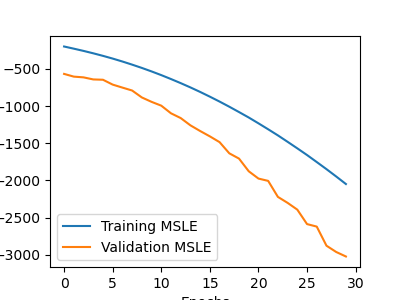

In [39]:
leaky_factor=0.2
drop_out=0.1
fraction=0.999
x_train_dim =x_values_conv.shape[1]
model2=get_minmax_conv_model(model, x_train_dim, leaky_factor, drop_out)
monitor_cb = CustomCallback(fraction,'loss' , 'val_loss')

In [40]:
history = model2.fit(x_values_conv,y_values,epochs=30,batch_size=64536, validation_split = 0.1, callbacks=[monitor_cb])

Epoch 1/30
34/34 [==============================] - 100s 3s/step - loss: -191.9651 - quadratic_metrics: 1.9974 - anti_quadratic_metrics: 193.9625 - val_loss: -567.3435 - val_quadratic_metrics: 175.9554 - val_anti_quadratic_metrics: 743.2989
Epoch 2/30
34/34 [==============================] - 97s 3s/step - loss: -221.8252 - quadratic_metrics: 4.1645 - anti_quadratic_metrics: 225.9897 - val_loss: -604.0289 - val_quadratic_metrics: 220.7806 - val_anti_quadratic_metrics: 824.8096
Epoch 3/30
34/34 [==============================] - 94s 3s/step - loss: -251.2485 - quadratic_metrics: 12.2493 - anti_quadratic_metrics: 263.4978 - val_loss: -613.9061 - val_quadratic_metrics: 234.1539 - val_anti_quadratic_metrics: 848.0600
Epoch 4/30
34/34 [==============================] - 94s 3s/step - loss: -282.5796 - quadratic_metrics: 26.4907 - anti_quadratic_metrics: 309.0703 - val_loss: -641.6949 - val_quadratic_metrics: 277.5741 - val_anti_quadratic_metrics: 919.2690
Epoch 5/30
34/34 [===================